In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt
import subprocess

In [2]:
def get_running_jobs():
    try:
        # Run the `bjobs` command and capture the output
        result = subprocess.run(['bjobs'], capture_output=True, text=True, check=True)
        lines = result.stdout.splitlines()
        
        # Extract information for running jobs
        running_jobs = []
        for line in lines[1:]:  # Skip the header
            columns = line.split()
            if len(columns) > 5 and columns[5] == "RUN":
                jobid = columns[0]
                queue = columns[2]
                job_name = columns[3]
                running_jobs.append((jobid, queue, job_name))
        
        return running_jobs
    except subprocess.CalledProcessError as e:
        print(f"Error running bjobs: {e}")
        return []


In [3]:
def plot(out_path, title):
    log_file = os.path.join(out_path, 'train.log')
    logs = pd.read_json(log_file, lines=True)

    # Steps vs training loss plot
    fig, ax1 = plt.subplots()

    ax1.plot(
        logs.step[logs.loss.notnull()],
        logs.loss[logs.loss.notnull()],
        label="on training set",
        color='tab:blue'
    )

    # Steps vs validation loss plot
    ax1.plot(
        logs.step[logs.valid_loss.notnull()],
        logs.valid_loss[logs.valid_loss.notnull()],
        label="on validation set",
        color='tab:orange'
    )

    ax1.set_xlabel('step')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='center left')

    if 'epoch' in logs:
        # Add secondary x-axis for 'epoch'
        ax2 = ax1.twiny()

        # Use the 'epoch' values directly from the logs DataFrame
        ax2.set_xlim(ax1.get_xlim())  # Make sure the limits of the secondary x-axis match the first x-axis

        # Get the steps where 'epoch' changes
        epoch_changes = logs[logs['epoch'].notnull()].drop_duplicates(subset='epoch', keep='first')

        # Set ticks based on the steps where 'epoch' changes
        ax2.set_xticks(epoch_changes.step)

        # Set labels to show the 'epoch' values only at those points
        ax2.set_xticklabels(epoch_changes.epoch)

        ax2.set_xlabel('Epoch')

    # Tight layout and saving the figure
    plt.tight_layout()

    l = logs.valid_loss[logs.valid_loss.notnull()].values[-1]
    title = f"{title}   (curr valid_loss = {l:.2f})"
    plt.title(title, pad=20)

    plt.show()

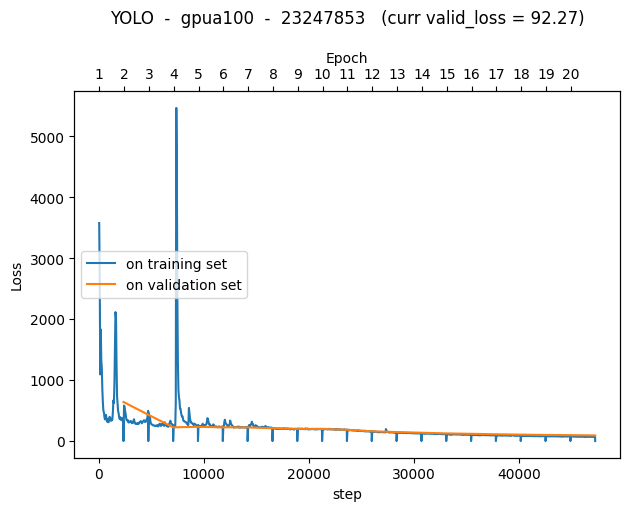

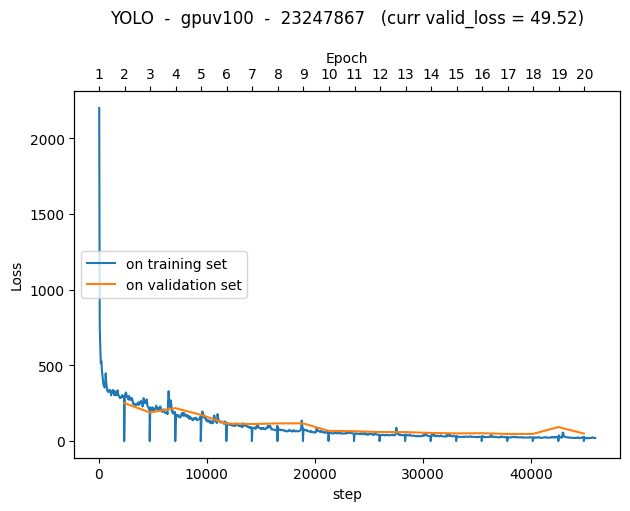

In [4]:
basepath = os.path.join(os.getenv('HOME'), 'deep-learning-project/job_out/')
running_jobs = get_running_jobs()

for id, queue, name in running_jobs:
    model = name.split('-')[-1]
    path = os.path.join(basepath, model, id)
    title = f"{model.upper()}  -  {queue}  -  {id}"

    plot(path, title)